In [1]:
import arcgis
import geopandas as gpd

/home/drastamat/projects/traffic_counts_dashboard/.venv/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
service_url = "https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/Traffic_Counts_view/FeatureServer/0"
traffic_featureservice = arcgis.features.FeatureLayer(service_url)
all_counts = traffic_featureservice.query()
sdf = all_counts.sdf
all_counts_gdf = gpd.GeoDataFrame(sdf, geometry=sdf.SHAPE)

In [4]:
service_url = "https://www.clevelandgis.org/arcgis/rest/services/ReferenceLayers/SPA/FeatureServer/0"
neighborhoods_featureservice = arcgis.features.FeatureLayer(service_url)
neighborhoods_query = neighborhoods_featureservice.query()
sdf = neighborhoods_query.sdf
neighborhoods_gdf = gpd.GeoDataFrame(sdf, geometry=sdf.SHAPE)

In [86]:
counts_sj = all_counts_gdf.sjoin(neighborhoods_gdf[['SPANM','geometry']], how='left')
counts_agg = counts_sj.groupby("SPANM").size()

In [20]:
crashes_url = "https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/Cleveland_Traffic_Crashes_view/FeatureServer/62"
crashes_featureservice = arcgis.features.FeatureLayer(crashes_url)
crashes_query = crashes_featureservice.query()
sdf = crashes_query.sdf
crashes_gdf = gpd.GeoDataFrame(sdf, geometry=sdf.SHAPE)

In [116]:
crashes_sj = crashes_gdf.sjoin(neighborhoods_gdf[['SPANM','geometry']], how='left')
crash_agg = (crashes_sj
    # Filter for crashes not occuring on interstates irrelevant to local context
    [crashes_sj['FUNCTIONAL_CLASS_CD'] != 1]
    # Count by crash severity type by neighborhood
    .pivot_table(index="SPANM", columns=['CRASH_SEVERITY_CD'], values=['OBJECTID'],aggfunc='count')\
    # Flatten column index
    .droplevel(0, axis=1)
    # Rename severity to plainer English
    .rename(columns={1.0: "Fatal",
                     2.0: "Serious",
                     3.0: "Minor Injury",
                     4.0: "Possible Injury",
                     5.0: "No Injury"})
    # Weighted index by severity 
    .assign(Weighted_Severity_Index= lambda x: x["Fatal"] *15
            + x['Serious'] *7
            + x["Minor Injury"] *3
            + x["Possible Injury"] *2
            + x['No Injury'] * 1)
)

In [132]:
# Final table
ratio_name = 'Index to Count Ratio'

analytics_result = crash_agg.merge(counts_agg.to_frame(), on='SPANM').rename(columns={0:'Traffic Counts Performed'})\
.assign(**{ratio_name: lambda x: x['Weighted_Severity_Index'] / x['Traffic Counts Performed']})\
.reset_index()

<Axes: xlabel='SPANM'>

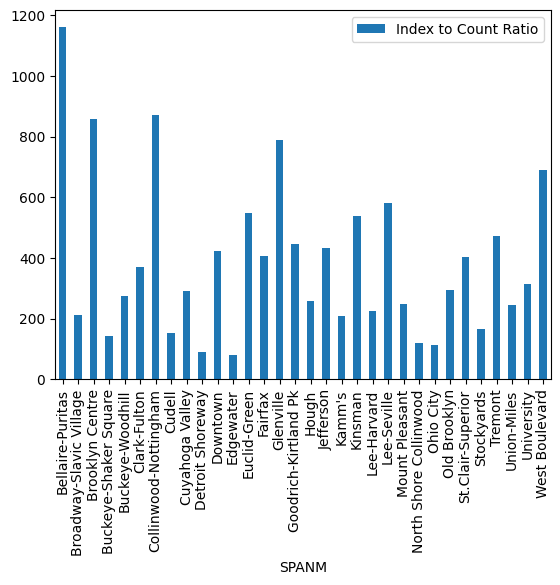

In [133]:
analytics_result.plot.bar(x='SPANM', y=ratio_name)